# Compute the distance between stations
2024.01.06 Kurama Okubo

This notebook computes the distances between the stations of HRSN. We also computed the coda init time and the corresponding linear trend. 

- 2023.5.2 cartopy 0.22 causes issue in plotting (https://github.com/SciTools/cartopy/issues/2086). Please use cartopy 0.21.

In [1]:
import datetime
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.dates as mdates
%matplotlib inline

import numpy as np
import pandas as pd
import h5py
import glob
import pickle

import shutil
from tqdm import tqdm

import matplotlib as mpl

# modules to compute distance
import cartopy.geodesic as cgeo

import itertools

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["xtick.minor.size"] = 2
plt.rcParams["xtick.minor.width"] = 1
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["ytick.minor.size"] = 2
plt.rcParams["ytick.minor.width"] = 1
plt.rcParams["ytick.minor.visible"] = True

os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion


In [2]:
# read BP station metadata
# read station loc and depth
loc_table = "./data/BP_gmap-stations.txt"
df_raw = pd.read_csv(loc_table, skiprows=3, header=None, sep = '|')

stationidlist = []
for i, row in df_raw.iterrows():
    stationidlist.append("{}.{}".format(row[0], row[1]))
    
dict_loc = {"id": stationidlist,
            "station": df_raw[1],
            "latitude": df_raw[2],
            "longitude": df_raw[3],
            "elevation": df_raw[4],
}
df_locorigin = pd.DataFrame.from_dict(dict_loc)

In [3]:
#make list of station depth
# Instrument depth is available in Malagnini2016 Table 1

stationdepth = {}
stationdepth["EADB"]=245
stationdepth["FROB"]=284
stationdepth["GHIB"]=63
stationdepth["JCNB"]=224
stationdepth["JCSB"]=155
stationdepth["MMNB"]=221
stationdepth["RMNB"]=73
stationdepth["SMNB"]=282 
stationdepth["VARB"]=298 
stationdepth["VCAB"]=200 
stationdepth["CCRB"]=251 
stationdepth["LCCB"]=252 
stationdepth["SCYB"]=252

df_stationdepth = pd.DataFrame(columns=["station", "depth"])
for d in stationdepth:
    df_stationdepth = pd.concat([df_stationdepth, pd.DataFrame({'station': d, 'depth': [stationdepth[d]]})])

df_locorigin = pd.merge(df_locorigin, df_stationdepth, on='station')
df_locorigin = df_locorigin.sort_values(by="station")
df_locorigin

,id,station,latitude,longitude,elevation,depth
0,BP.CCRB,CCRB,35.95718,-120.55158,595.0,251
1,BP.EADB,EADB,35.89522,-120.42262,469.0,245
2,BP.FROB,FROB,35.91095,-120.48688,515.0,284
3,BP.GHIB,GHIB,35.83225,-120.34728,393.0,63
4,BP.JCNB,JCNB,35.93897,-120.43112,533.0,224
5,BP.JCSB,JCSB,35.92117,-120.43400,454.0,155
6,BP.LCCB,LCCB,35.98006,-120.51423,637.0,252
7,BP.MMNB,MMNB,35.95650,-120.49600,701.0,221
8,BP.RMNB,RMNB,36.00087,-120.47772,1164.0,73
9,BP.SCYB,SCYB,36.00942,-120.53661,947.0,252


In [4]:
ni = 0
for sta1, sta2 in itertools.combinations(df_locorigin["id"].values, 2):
    # print(sta1, sta2)
    ni = ni + 1

print(f"total number of pairs: {ni}")

total number of pairs: 78


# Plot stations

In [5]:
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)

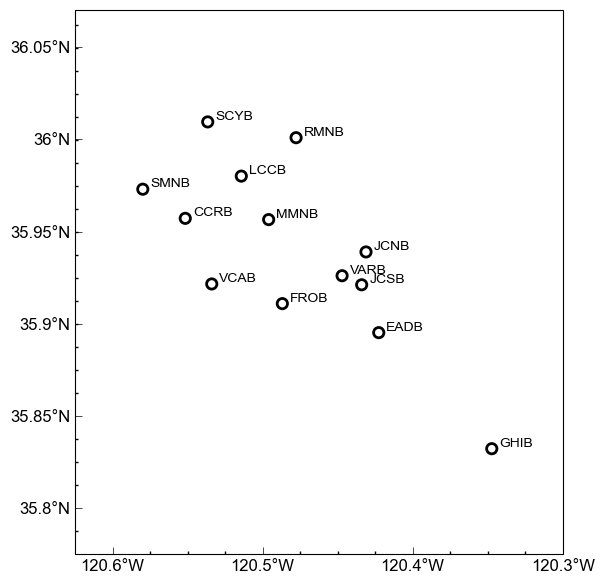

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), subplot_kw={'projection': ccrs.Mercator()})
f_lon_min = -120.625
f_lon_max = -120.3
f_lat_min = 35.775
f_lat_max = 36.07

#---Plot stations---#
for k, row in df_locorigin.iterrows():
    staid = row.id
    sta = row.station
    lon, lat, elevation, depth = row.longitude, row.latitude, row.elevation, row.depth
    ax.scatter(lon,lat, s=55, facecolors='none',  edgecolors='black',
                    linestyle="-", linewidth=2, zorder=6, transform=ccrs.PlateCarree())
    ax.text(lon+0.005, lat+0.001, sta, fontsize=10, transform=ccrs.PlateCarree())


# #---plot fault geometry---#
# for sfkey in dict_sf:
#     faultx = dict_sf[sfkey][0]
#     faulty = dict_sf[sfkey][1]
#     min_x, min_y = [np.min(faultx), np.min(faulty)]
#     max_x, max_y = [np.max(faultx), np.max(faulty)]

#     if (min_x > f_lon_min) & (max_x < f_lon_max) & (min_y > f_lat_min) & (max_y < f_lat_max):
#         ax.plot(faultx, faulty, 'k', ls="-", lw=1.0, zorder=-2, transform=ccrs.PlateCarree())
# #-------------------------------#

# #---Plot approximated fault loc---#
# ax.plot([approx_faultloc[0], approx_faultloc[2]], [approx_faultloc[1], approx_faultloc[3]],
#             'bo', ls="--", lw=1.0, zorder=-2, transform=ccrs.PlateCarree())
# #-------------------------------------------#

ax.set_extent([f_lon_min, f_lon_max, f_lat_min, f_lat_max], crs=ccrs.PlateCarree())

ax.set_xticks(np.arange(-120.6, -120.2, 0.1), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(35.8, 36.075, 0.05), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True, dms=False)
lat_formatter = LatitudeFormatter(dms=False)
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

fig.tight_layout()


## Read the model parameter of linear trend

In [7]:
df_model = pd.read_csv("./data/DataSetS5_MCMC_modelparam_all_allcases_master.csv", index_col=0)

In [8]:
df_model_wlin = df_model[df_model["modelcase"] == "wlin"].copy()

# remove FROB
df_model_wlin = df_model_wlin[["FROB" not in x for x in df_model_wlin.index]]

In [9]:
df_model_wlin.loc[:, "blin_1overyear"] = df_model_wlin["b_{lin}"].apply(lambda x: x*365)


In [10]:
df_tmp = df_model_wlin[df_model_wlin.index == "BP.VCAB-BP.VCAB"]

In [11]:
df_model_wlin

,dvvmethod,modelcase,freqband,a0,p1,a_{precip},p2,t_{shiftdays},S1,log10tmin1,...,S2,log10tmin2,log10tmax2,b_{lin},logf,AIC,BIC,residu_absmean,residu_var,blin_1overyear
BP.CCRB-BP.CCRB,stretching,wlin,0.9-1.2,-0.050196,-0.001438,0.02426,0.001343,1.970812,0.011752,6.293,...,0.024233,6.996,8.922855,0.000012,-4.044325,-7597.281362,-7543.774765,0.017204,0.000491,0.004446
BP.CCRB-BP.EADB,stretching,wlin,0.9-1.2,-0.042284,-0.004332,0.02426,-0.000183,38.992332,0.015520,6.293,...,0.045176,6.996,8.617927,0.000011,-4.199614,-7131.789862,-7078.661790,0.020481,0.000856,0.004016
BP.CCRB-BP.JCSB,stretching,wlin,0.9-1.2,-0.005139,-0.007616,0.02426,-0.001434,89.689270,0.006426,6.293,...,0.013955,6.996,9.108440,0.000009,-9.559013,-6119.589574,-6067.603398,0.034734,0.002370,0.003120
BP.CCRB-BP.LCCB,stretching,wlin,0.9-1.2,-0.020279,-0.003624,0.02426,-0.000450,5.782466,0.008481,6.293,...,0.017790,6.996,9.902057,0.000013,-4.255874,-7288.278229,-7235.150158,0.018931,0.000602,0.004815
BP.CCRB-BP.MMNB,stretching,wlin,0.9-1.2,-0.034732,-0.003584,0.02426,-0.000724,0.549409,0.015478,6.293,...,0.035215,6.996,8.624071,0.000009,-3.862281,-6883.447112,-6830.831274,0.020956,0.000801,0.003454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BP.SMNB-BP.SMNB,mwcs,wlin,0.9-1.2,-0.004944,-0.000089,0.03888,0.000895,0.635257,0.006140,4.903,...,0.091350,6.993,7.548877,0.000004,-3.222858,-7300.463339,-7246.533251,0.029984,0.001589,0.001353
BP.SMNB-BP.VARB,mwcs,wlin,0.9-1.2,-0.025241,-0.008938,0.03888,-0.001394,24.623070,0.000906,4.903,...,0.062471,6.993,7.674540,0.000008,-2.827522,-4987.924525,-4938.263447,0.041836,0.003454,0.003053
BP.SMNB-BP.VCAB,mwcs,wlin,0.9-1.2,-0.037177,-0.007962,0.03888,-0.001224,88.912238,0.004194,4.903,...,0.066288,6.993,7.569370,0.000011,-3.366526,-7355.132381,-7301.341929,0.023675,0.001192,0.004133
BP.VARB-BP.VARB,mwcs,wlin,0.9-1.2,0.026117,-0.000943,0.03888,0.001194,35.129115,0.000004,4.903,...,0.005211,6.993,11.660483,0.000005,-2.371332,-4966.691399,-4916.244470,0.071081,0.008776,0.001792


In [12]:
blin_stretching = df_tmp[df_tmp["dvvmethod"]=="stretching"]["blin_1overyear"].values[0]
blin_mwcs = df_tmp[df_tmp["dvvmethod"]=="mwcs"]["blin_1overyear"].values[0]

In [13]:
# Compute distance and coda init window

background_vel = 1000.0 # [m/s] approximation of the wave velocity to determine the ballistic wave arrival
min_ballistic_twin = 5.0
coda_init_factor = 2.0
residu_var_thresh = 0.002

df_stationdist = pd.DataFrame(columns=["sta1", "sta2", "distance[km]", "coda_init[s]", "b_stretching[%/y]", "b_mwcs[%/y]"])

geodesic = cgeo.Geodesic()

ni = 0

# add auto-correlation
for sta in df_locorigin["id"].values:

    statinopair = f"{sta}-{sta}"
    df_tmp = df_model_wlin[df_model_wlin.index == statinopair]

    if len(df_tmp) != 0:
        blin_stretching = df_tmp[df_tmp["dvvmethod"]=="stretching"]["blin_1overyear"].values
        blin_mwcs = df_tmp[df_tmp["dvvmethod"]=="mwcs"]["blin_1overyear"].values

        residu_var_stretching = df_tmp[df_tmp["dvvmethod"]=="stretching"]["residu_var"].values
        residu_var_mwcs = df_tmp[df_tmp["dvvmethod"]=="mwcs"]["residu_var"].values
        
        if blin_stretching.size==0:
            blin_stretching = np.nan
        else:
            if residu_var_stretching <= residu_var_thresh:
                blin_stretching = blin_stretching[0]
            else:
                blin_stretching = np.nan

        if blin_mwcs.size==0:
            blin_mwcs = np.nan
        else:
            if residu_var_mwcs <= residu_var_thresh:
                blin_mwcs = blin_mwcs[0]
            else:
                blin_mwcs = np.nan

    else:
        blin_stretching = np.nan
        blin_mwcs = np.nan
        
    df_stationdist =  pd.concat([df_stationdist, pd.DataFrame({'sta1': sta, 'sta2': sta, 'distance[km]': [0], "coda_init[s]": [min_ballistic_twin],
                                                               "b_stretching[%/y]": [blin_stretching], "b_mwcs[%/y]":[blin_mwcs]})])
    ni = ni + 1

# cross-correlation
for sta1, sta2 in itertools.combinations(df_locorigin["id"].values, 2):
    # print(sta1, sta2)
    df_sta1 = df_locorigin[df_locorigin["id"]==sta1]
    df_sta2 = df_locorigin[df_locorigin["id"]==sta2]

    dist = geodesic.inverse([df_sta1.longitude.values[0], df_sta1.latitude.values[0]],
                        [df_sta2.longitude.values[0], df_sta2.latitude.values[0]])[0, 0]

    coda_init = coda_init_factor * dist / background_vel

    # search blin
    statinopair = f"{sta1}-{sta2}"
    df_tmp = df_model_wlin[df_model_wlin.index == statinopair]

    if len(df_tmp) != 0:
        blin_stretching = df_tmp[df_tmp["dvvmethod"]=="stretching"]["blin_1overyear"].values
        blin_mwcs = df_tmp[df_tmp["dvvmethod"]=="mwcs"]["blin_1overyear"].values

        residu_var_stretching = df_tmp[df_tmp["dvvmethod"]=="stretching"]["residu_var"].values
        residu_var_mwcs = df_tmp[df_tmp["dvvmethod"]=="mwcs"]["residu_var"].values
        
        if blin_stretching.size==0:
            blin_stretching = np.nan
        else:
            if residu_var_stretching <= residu_var_thresh:
                blin_stretching = blin_stretching[0]
            else:
                blin_stretching = np.nan

        if blin_mwcs.size==0:
            blin_mwcs = np.nan
        else:
            if residu_var_mwcs <= residu_var_thresh:
                blin_mwcs = blin_mwcs[0]
            else:
                blin_mwcs = np.nan
            
    else:
        blin_stretching = np.nan
        blin_mwcs = np.nan
    
    df_stationdist =  pd.concat([df_stationdist, pd.DataFrame({'sta1': sta1, 'sta2': sta2, 'distance[km]': [dist/1e3],
                                                               "coda_init[s]": [np.max([min_ballistic_twin, coda_init])],
                                                               "b_stretching[%/y]": [blin_stretching], "b_mwcs[%/y]":[blin_mwcs]})])
    ni = ni + 1

print(f"total number of pairs: {ni}")

total number of pairs: 91


In [14]:
df_stationdist

,sta1,sta2,distance[km],coda_init[s],b_stretching[%/y],b_mwcs[%/y]
0,BP.CCRB,BP.CCRB,0,5.000000,0.004446,0.001776
0,BP.EADB,BP.EADB,0,5.000000,0.004911,0.002997
0,BP.FROB,BP.FROB,0,5.000000,NaN,NaN
0,BP.GHIB,BP.GHIB,0,5.000000,0.013355,NaN
0,BP.JCNB,BP.JCNB,0,5.000000,NaN,NaN
...,...,...,...,...,...,...
0,BP.SCYB,BP.VARB,12.278913,24.557826,NaN,NaN
0,BP.SCYB,BP.VCAB,9.745165,19.490331,0.004894,0.001552
0,BP.SMNB,BP.VARB,13.064734,26.129467,NaN,NaN
0,BP.SMNB,BP.VCAB,7.04689,14.093781,0.005262,0.004133


In [15]:
df_out = df_stationdist.copy().sort_values(by='distance[km]')
df_out['distance[km]'] = df_out['distance[km]'].astype(float)

In [16]:
df_out = df_out.round({'distance[km]': 2, 'coda_init[s]': 2, 'b_stretching[%/y]': 5, 'b_mwcs[%/y]': 5})

In [17]:
df_out.to_csv("./data/BP_station_distance.csv", index=False)

In [18]:
print(f"maximum station distances:{df_stationdist['distance[km]'].max():.2f}km")

maximum station distances:26.17km


In [19]:
N_stretching = np.count_nonzero(~np.isnan(df_out["b_stretching[%/y]"]))
N_mwcs = np.count_nonzero(~np.isnan(df_out["b_mwcs[%/y]"]))
print(N_stretching, N_mwcs, ": 32 and 29 are identical to the number written in manuscript")

32 29 : 32 and 29 are identical to the number written in manuscript


In [20]:
# Search the excluded station pairs

In [21]:
stationpairs = np.array(['BP.CCRB-BP.CCRB', 'BP.CCRB-BP.EADB', 'BP.CCRB-BP.FROB',
       'BP.CCRB-BP.JCNB', 'BP.CCRB-BP.JCSB', 'BP.CCRB-BP.LCCB',
       'BP.CCRB-BP.MMNB', 'BP.CCRB-BP.RMNB', 'BP.CCRB-BP.SCYB',
       'BP.CCRB-BP.SMNB', 'BP.CCRB-BP.VARB', 'BP.CCRB-BP.VCAB',
       'BP.EADB-BP.EADB', 'BP.EADB-BP.FROB', 'BP.EADB-BP.GHIB',
       'BP.EADB-BP.JCNB', 'BP.EADB-BP.JCSB', 'BP.EADB-BP.LCCB',
       'BP.EADB-BP.MMNB', 'BP.EADB-BP.RMNB', 'BP.EADB-BP.SCYB',
       'BP.EADB-BP.SMNB', 'BP.EADB-BP.VARB', 'BP.EADB-BP.VCAB',
       'BP.FROB-BP.FROB', 'BP.FROB-BP.GHIB', 'BP.FROB-BP.JCNB',
       'BP.FROB-BP.JCSB', 'BP.FROB-BP.LCCB', 'BP.FROB-BP.MMNB',
       'BP.FROB-BP.RMNB', 'BP.FROB-BP.SCYB', 'BP.FROB-BP.SMNB',
       'BP.FROB-BP.VARB', 'BP.FROB-BP.VCAB', 'BP.GHIB-BP.GHIB',
       'BP.GHIB-BP.JCNB', 'BP.GHIB-BP.JCSB', 'BP.GHIB-BP.VARB',
       'BP.JCNB-BP.JCNB', 'BP.JCNB-BP.JCSB', 'BP.JCNB-BP.LCCB',
       'BP.JCNB-BP.MMNB', 'BP.JCNB-BP.SCYB', 'BP.JCNB-BP.SMNB',
       'BP.JCNB-BP.VARB', 'BP.JCNB-BP.VCAB', 'BP.JCSB-BP.JCSB',
       'BP.JCSB-BP.LCCB', 'BP.JCSB-BP.MMNB', 'BP.JCSB-BP.RMNB',
       'BP.JCSB-BP.SCYB', 'BP.JCSB-BP.SMNB', 'BP.JCSB-BP.VARB',
       'BP.JCSB-BP.VCAB', 'BP.LCCB-BP.LCCB', 'BP.LCCB-BP.MMNB',
       'BP.LCCB-BP.RMNB', 'BP.LCCB-BP.SCYB', 'BP.LCCB-BP.SMNB',
       'BP.LCCB-BP.VARB', 'BP.LCCB-BP.VCAB', 'BP.MMNB-BP.MMNB',
       'BP.MMNB-BP.RMNB', 'BP.MMNB-BP.SCYB', 'BP.MMNB-BP.SMNB',
       'BP.MMNB-BP.VARB', 'BP.MMNB-BP.VCAB', 'BP.RMNB-BP.RMNB',
       'BP.RMNB-BP.SCYB', 'BP.RMNB-BP.SMNB', 'BP.RMNB-BP.VARB',
       'BP.RMNB-BP.VCAB', 'BP.SCYB-BP.SCYB', 'BP.SCYB-BP.SMNB',
       'BP.SCYB-BP.VARB', 'BP.SCYB-BP.VCAB', 'BP.SMNB-BP.SMNB',
       'BP.SMNB-BP.VARB', 'BP.SMNB-BP.VCAB', 'BP.VARB-BP.VARB',
       'BP.VARB-BP.VCAB', 'BP.VCAB-BP.VCAB'], dtype=object)

In [22]:
len(stationpairs)

83

In [23]:
for i, row in df_stationdist.iterrows():
    flag = 0
    for pair in stationpairs:
        if (row.sta1 in pair) & (row.sta2 in pair):
            flag=1
            # print(row)
    if flag==0:
        print(f"{row} is missing.")

sta1                   BP.CCRB
sta2                   BP.GHIB
distance[km]         23.073035
coda_init[s]         46.146071
b_stretching[%/y]          NaN
b_mwcs[%/y]                NaN
Name: 0, dtype: object is missing.
sta1                   BP.GHIB
sta2                   BP.LCCB
distance[km]         22.273377
coda_init[s]         44.546753
b_stretching[%/y]          NaN
b_mwcs[%/y]                NaN
Name: 0, dtype: object is missing.
sta1                   BP.GHIB
sta2                   BP.MMNB
distance[km]         19.244463
coda_init[s]         38.488925
b_stretching[%/y]          NaN
b_mwcs[%/y]                NaN
Name: 0, dtype: object is missing.
sta1                   BP.GHIB
sta2                   BP.RMNB
distance[km]         22.105697
coda_init[s]         44.211394
b_stretching[%/y]          NaN
b_mwcs[%/y]                NaN
Name: 0, dtype: object is missing.
sta1                   BP.GHIB
sta2                   BP.SCYB
distance[km]         26.046892
coda_init[s]         52

In [24]:
row.sta1 in stationpairs[-5]

True

In [25]:
row.sta1

'BP.VARB'